## This code is mainly for:
## 1. Cleaning the data 
## 2. Properly separating(train/test) the data
## 3. Data normalization 
### by German Perea

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import datetime
from sklearn.model_selection import train_test_split


### The raw data to clean are saved as 
### 1. logs.csv
### 2. amp_data.txt
### 3. voltage_data.txt


In [85]:
# Read the data 

Logs = pd.read_csv('logs.csv')
amps = pd.read_csv('amp_data.txt', header=None)
volts = pd.read_csv('voltage_data.txt', header=None)


# Make a copy, to prevent changes in the original dataset 
amp = amps.copy()
volt = volts.copy()



In [86]:
# Column 0 represents Unix time for both amps and volts

unix = amp[0]

# This converts the Unix time into a Datetime format 
# The following Converts to 

x = pd.to_datetime(pd.Series(np.asarray(unix, dtype='datetime64[ms]')))


# Convert the time into United States Central time

central_time = x.dt.tz_localize("UTC").dt.tz_convert('US/Central')

amp['Date'] = central_time

# Sanity: check if the Values from Unix values from AMPS and Volts 
# are the same 

# Combine Amps and Volts together 

amp = amp.rename(columns = {1:'Ampere'})

he = [str(i).replace(" ","") for i in volt[1]]

# found the mistake, some values of in the amps are actually saved as 'None'


In [87]:
# There are some values that are none 

volt1 = volt[[j!='None'for j in he]]

volt = np.array(volt1[1], dtype = float)


In [88]:
# 
cl = [str(i).replace(" ","") for i in amp['Ampere']]

# Add the Voltage and Ampere columns

amp1 = amp[[k!='None' for k in cl]]
amp1['Ampere'] = np.array(amp1['Ampere'], dtype = float)
amp1['Voltage'] = volt
amp1.head()



/Users/germa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/germa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,0,Ampere,Date,Voltage
0,1554076800000,686.70,2019-03-31 19:00:00-05:00,593.0
1,1554077100000,684.08,2019-03-31 19:05:00-05:00,592.0
2,1554077400000,654.49,2019-03-31 19:10:00-05:00,593.6
3,1554077700000,670.80,2019-03-31 19:15:00-05:00,592.0
4,1554078000000,651.67,2019-03-31 19:20:00-05:00,592.3


In [89]:
amp_and_vol = amp1
amp_and_vol = amp_and_vol.drop(columns = [0])

# Make a copy of the original data 

modified_log = Logs.copy()
modified_log = modified_log.drop(columns = 'Unnamed: 0')


# ts: is in ts(timestime: in central time)
# Battery: positive values stand for charging 

modified_log['ts'] = pd.to_datetime(pd.Series(np.asarray(modified_log['ts'], dtype='datetime64[s]')))
# This is to match the correct 
# data format from Logs
amp_and_vol['Date'] = pd.to_datetime(amp_and_vol['Date'].dt.strftime(('%B %d, %Y, %r')))





In [90]:
# Let's join the data based on the DataFrame where we know the State of Charge

# There are values where we don't have Amps and Voltage for the original data
# The original values with SOC is 40427, but not all SOC have AMPS and Volts
# We will drop these values: After dropping missing values, we have 34627 rows left 

modified = modified_log.join(amp_and_vol.set_index('Date'), on='ts').dropna().reset_index(drop=True)




## Train Test Split process

In [91]:
X = modified 

X = X.rename(columns = {'Battery': 'Battery(kW)', 'building': 'Building(kW)', 'Adjusted Load': 'Adjusted Load (kW)'})


# Drop the rows in which the building has Negative Power

X = X[X['Building(kW)']>0]


### Correlation Plotting

### Nonlinear autoregressive exogenous model

Exogenous inputs (the model relates the current value of a time)

1. Past values of the same series 
2. Current and past values of the driving (exogenous) series — that is, of the externally determined series that influences the series of interest.


documentation on how to use NARX in Python:

https://firets.readthedocs.io/en/latest/models.html

parameters:

https://pypi.org/project/fireTS/


In [92]:
X['deltaSOC'] = X[['State of Charge']].diff(1, axis=0)['State of Charge']


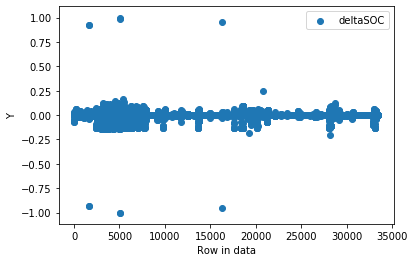

In [93]:
# Recommend 
plt.scatter(np.arange(len(X)),X['deltaSOC'][0:len(X)])
#plt.plot(np.arange(len(X)),X['State of Charge'][0:len(X)])
plt.xlabel('Row in data')
plt.ylabel('Y')
plt.legend(['deltaSOC'])
#plt.title('SOC and deltaSOC')




Text(0.5, 1.0, 'Power')

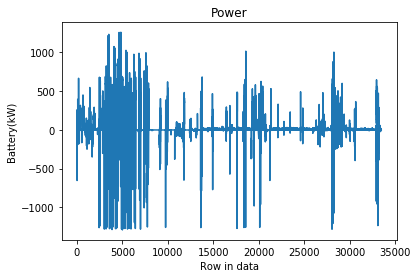

In [95]:
plt.plot(np.arange(len(X)),X['Battery(kW)'][0:len(X)])
plt.ylabel('Battery(kW)')
plt.xlabel('Row in data')
plt.title('Power')


Text(0.5, 1.0, 'Power')

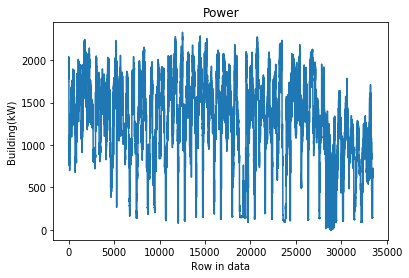

In [96]:
plt.plot(np.arange(len(X)),X['Building(kW)'][0:len(X)])
plt.ylabel('Building(kW)')
plt.xlabel('Row in data')
plt.title('Power')



Text(0.5, 1.0, 'Current')

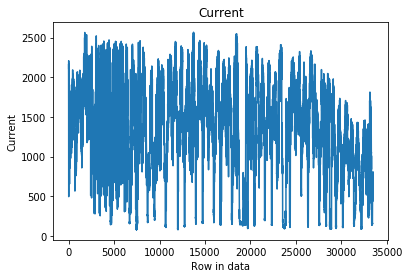

In [97]:
plt.plot(np.arange(len(X)),X['Ampere'][0:len(X)])
plt.ylabel('Current')
plt.xlabel('Row in data')
plt.title('Current')




## First need to install NN in your computer 

In [98]:
# Dropping the first row in data

X_new = X.copy()
X_new = X_new.iloc[1:]



In [99]:
# Install neural network 
# Features Total Net Load (Sum of All Loads excluding Battery)= 
X_stats = X_new.describe()
X_stats = X_stats.transpose()


## Randomly generate values for each week and month



In [101]:
def norm(data):
    """Returns an """
    return (data - X_stats['mean'])/X_stats['std']

def norm3(data):
    return (2*(data - X_stats['min'])/(X_stats['max']-X_stats['min']) - 1)


In [102]:
# normalizing the data 
norm3(X_new.drop(columns = 'ts'))

X_normalized = norm3(X_new.drop(columns = 'ts'))


In [103]:
X_normalized.head()

,Battery(kW),State of Charge,Total Net Load (Sum of All Loads excluding Battery),Building(kW),Adjusted Load (kW),Ampere,Voltage,deltaSOC
1,0.121377,0.171272,0.697911,0.697911,0.813409,0.678746,0.091142,0.013388
2,0.006420,0.167741,0.714041,0.714041,0.712926,0.567783,0.119384,-0.001765
3,-0.390134,0.055239,0.670763,0.670763,0.275912,0.065651,0.206675,-0.056255
4,0.112608,0.084222,0.699128,0.699128,0.805731,0.711337,0.080873,0.014493
5,0.156146,0.119256,0.668845,0.668845,0.821699,0.099766,0.160462,0.017518


In [104]:
X['Year'] = X['ts'].dt.year
X['Week'] = X['ts'].dt.week
X['Hour'] = X['ts'].dt.hour
X['Day'] = X['ts'].dt.weekday


In [105]:
group = X.groupby(['Year','Week','Day']).count()


In [106]:
# We have 358 days worth of data 

ty = X[X['Week']==23]

ty[X['Day']==3]




/Users/germa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,Battery(kW),State of Charge,Total Net Load (Sum of All Loads excluding Battery),ts,Building(kW),Adjusted Load (kW),Ampere,Voltage,deltaSOC,Year,Week,Hour,Day
459,0.000000,0.995694,1804.371576,2019-06-06 00:00:00,1804.371576,1804.371576,1839.53,583.4,-0.000026,2019,23,0,3
460,0.400004,0.995680,1850.625828,2019-06-06 00:15:00,1850.625828,1851.025832,1800.75,586.7,-0.000014,2019,23,0,3
461,0.000000,0.995634,1831.426420,2019-06-06 00:30:00,1831.426420,1831.426420,1830.21,586.7,-0.000045,2019,23,0,3
462,0.400005,0.995647,1827.047468,2019-06-06 00:45:00,1827.047468,1827.447473,1764.53,587.5,0.000013,2019,23,0,3
463,-8.799982,0.994731,1722.654645,2019-06-06 01:00:00,1722.654645,1713.854663,1804.63,586.7,-0.000917,2019,23,1,3
464,-0.399976,0.994689,1686.017697,2019-06-06 01:15:00,1686.017697,1685.617721,1822.61,585.7,-0.000041,2019,23,1,3
465,-0.799979,0.994604,1754.753940,2019-06-06 01:30:00,1754.753940,1753.953961,1832.37,586.6,-0.000085,2019,23,1,3
466,2.400024,0.994840,1792.091732,2019-06-06 01:45:00,1792.091732,1794.491756,1776.90,587.4,0.000236,2019,23,1,3
467,0.800015,0.994932,1811.006188,2019-06-06 02:00:00,1811.006188,1811.806203,1728.62,589.1,0.000092,2019,23,2,3
468,9.999998,0.995915,1793.047697,2019-06-06 02:15:00,1793.047697,1803.047694,1804.48,588.0,0.000982,2019,23,2,3


#### This will capture true reprentation


In [107]:
# Training a NN and do it in Matlab 

# 
# Send percentage
# Need to know the neurons, loss function, activation, layers

X['deltaSOC'].iloc[0] = X['deltaSOC'].iloc[1]

In [108]:
gr = X[['Year','Week','Day']].groupby(['Year','Week']).size()



In [109]:
#X[['Year','Week','Day']].groupby(['Year','Week']).size()

# Do it for 1 year first 
Z = X

CV = Z.groupby(['Year','Week','Day']).size(
).index.get_level_values(1).value_counts()


tu = pd.DataFrame(CV).rename(columns = {'Week':'values'})

X = X.join(tu, on = 'Week')


In [110]:

bo = (X['Year']==2019) & (X['Week']==22)
nt = (X['Year']==2020) & (X['Week']==22)


In [111]:
X.loc[bo, 'values'] = 2
X.loc[nt, 'values'] = 7

In [112]:
X['date'] = X['ts'].dt.strftime("%Y-%m-%d")


In [113]:
MN = X
bv = MN[['Week', 'values','date']].apply(tuple, axis=1)
MN['Triple'] = bv 

bv2 =  MN[['Week', 'values']].apply(tuple, axis = 1)
MN['Pairs'] = bv2


In [114]:
# This is important 
L = MN['Triple'].unique()




In [115]:
# [list(j) for j in bv.unique()]

#[i[1] for i in bv.unique()]
#MN['date'].unique()

el = pd.DataFrame({'We':[x[0] for x in L], 'Va': [x[1] for x in L], 'Date': [x[2] for x in L]})




In [116]:
tr = pd.DataFrame(el.groupby(['We','Va']).apply(lambda x: list(x['Date'])))

 


In [48]:
table = pd.pivot_table(el, values= 'Date', index=['We'],
                    columns=['Va'], aggfunc = lambda x: list(x))



In [117]:
zero = tr.index.get_level_values(0)


In [118]:
one = tr.index.get_level_values(1)
one
gt = pd.DataFrame({'X':zero, 'Y':one}).apply(tuple, axis=1)

gt.values


array([(1, 7), (2, 7), (3, 7), (4, 7), (5, 7), (6, 7), (7, 7), (8, 7),
       (9, 7), (10, 7), (11, 7), (12, 7), (13, 7), (14, 7), (15, 7),
       (16, 7), (17, 7), (18, 7), (19, 7), (20, 7), (21, 7), (22, 2),
       (22, 7), (23, 7), (24, 7), (25, 7), (26, 7), (27, 7), (28, 7),
       (29, 7), (30, 7), (31, 7), (32, 7), (33, 7), (34, 7), (35, 7),
       (36, 7), (37, 7), (38, 7), (39, 2), (40, 6), (41, 7), (42, 7),
       (43, 7), (44, 7), (45, 7), (46, 7), (47, 7), (48, 7), (49, 7),
       (50, 7), (51, 7), (52, 5)], dtype=object)

In [119]:
tr['Pairs'] = gt.values

In [120]:
tr = tr.reset_index(drop=True).rename(columns = {0: 'lstDates'})



In [121]:
# The following is how we are separating the data 
we = [x[0] for x in tr['Pairs']]
days = [x[1] for x in tr['Pairs']]



In [122]:
def trainSplit(dat):
    """Returns: dates that are suppose to go with
       train data"""
    np.random.seed(40)
    train = []
    we = [x[0] for x in dat['Pairs']] # the number of weeks
    days = [x[1] for x in dat['Pairs']] # the number of days
    ch = np.random.choice
    for i,j in zip(np.arange(len(we)), days):
        if j == 2:
            train.extend(ch(dat.iloc[i]['lstDates'], 1, replace = False))
            #Weeks with 2 days: extend 1 dates
       
        elif j == 5:
            train.extend(ch(dat.iloc[i]['lstDates'], 3, replace = False))
             #Weeks with 5 days: extend 3 dates
        
        elif j == 6:
            train.extend(ch(dat.iloc[i]['lstDates'], 3, replace = False))
            #Weeks with 6 days: extend 3 dates
        
        else:
            train.extend(ch(dat.iloc[i]['lstDates'], 5, replace = False))
            #Weeks with 7 days: extend 5 days
    return train




In [123]:
# iterate through the pairs column and get select random dates from

# lstDates column
train_dates = trainSplit(tr)


In [124]:
# The following is the dataframe for training

training_data = MN[MN['date'].isin(train_dates)]

100*(len(training_data)/len(MN))


70.65726998536745

In [125]:
# The following is for testing data
testing_data = MN[MN['date'].isin(train_dates)==False]


Text(0.5, 1.0, 'Training: Current')

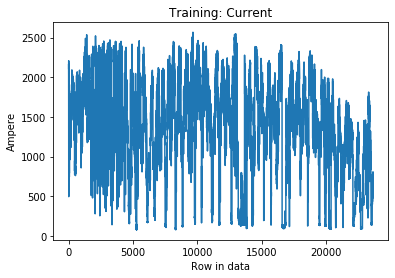

In [126]:
plt.plot(np.arange(len(training_data)),training_data['Ampere'][0:len(training_data)])
plt.ylabel('Ampere')
plt.xlabel('Row in data')
plt.title('Training: Current')


Text(0.5, 1.0, 'Testing: Current')

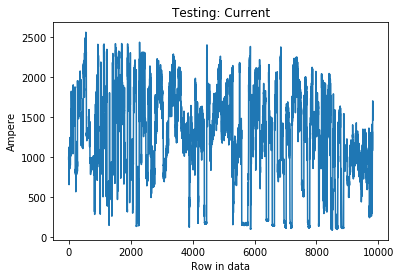

In [127]:
plt.plot(np.arange(len(testing_data)),testing_data['Ampere'][0:len(testing_data)])
plt.ylabel('Ampere')
plt.xlabel('Row in data')
plt.title('Testing: Current')



In [128]:
# plt.scatter(np.arange(len(testing_data)),testing_data['deltaSOC'][0:len(testing_data)])
# plt.ylabel('Units in Decimal')
# plt.xlabel('Row in data')
# plt.title('Testing: deltaSOC')



Text(0.5, 1.0, 'Testing: deltaSOC')

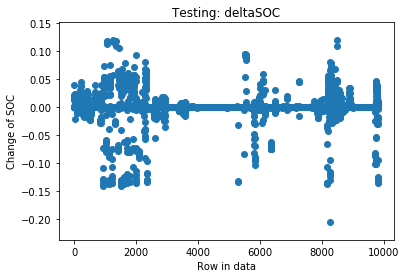

In [129]:
plt.scatter(np.arange(len(testing_data)),testing_data['deltaSOC'][0:len(testing_data)])
plt.ylabel('Change of SOC')
plt.xlabel('Row in data')
plt.title('Testing: deltaSOC')




Text(0.5, 1.0, 'Training: deltaSOC')

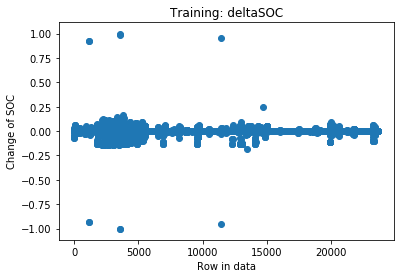

In [130]:
plt.scatter(np.arange(len(training_data)),training_data['deltaSOC'][0:len(training_data)])
plt.ylabel('Change of SOC')
plt.xlabel('Row in data')
plt.title('Training: deltaSOC')



Text(0.5, 1.0, 'Training: SOC')

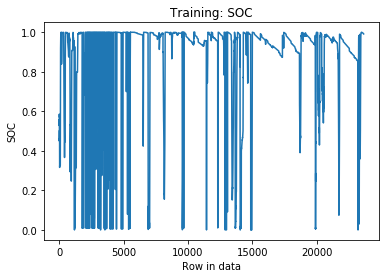

In [131]:
plt.plot(np.arange(len(training_data)),training_data['State of Charge'][0:len(training_data)])
plt.ylabel('SOC')
plt.xlabel('Row in data')
plt.title('Training: SOC')



Text(0.5, 1.0, 'Testing: SOC')

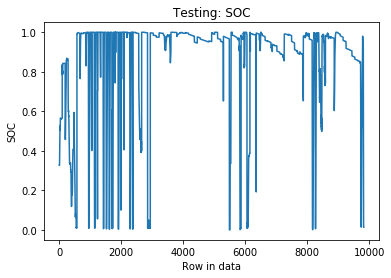

In [132]:
plt.plot(np.arange(len(testing_data)),testing_data['State of Charge'][0:len(testing_data)])
plt.ylabel('SOC')
plt.xlabel('Row in data')
plt.title('Testing: SOC')


## Install Neural Network
#### $ pip install neuralnetwork

##### How to use NN?

https://pypi.org/project/neuralnetwork/

In [133]:
# input_nodes = 2
# hidden_nodes = 2
# output_nodes = 2

# output_order = 3
# incoming_weight_from_output = .6
# input_order = 2
# incoming_weight_from_input = .4

# net = neuralnetwork



#### Install Pyneurgen
$ pip install pyneurgen


Text(0.5, 1.0, 'Testing: Voltage')

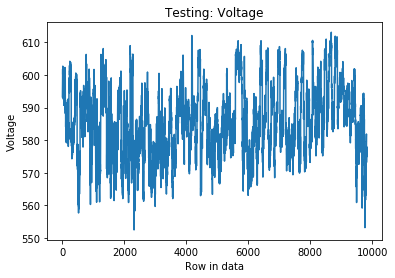

In [66]:
plt.plot(np.arange(len(testing_data)),testing_data['Voltage'][0:len(testing_data)])
plt.ylabel('Voltage')
plt.xlabel('Row in data')
plt.title('Testing: Voltage')


Text(0.5, 1.0, 'Training: Voltage')

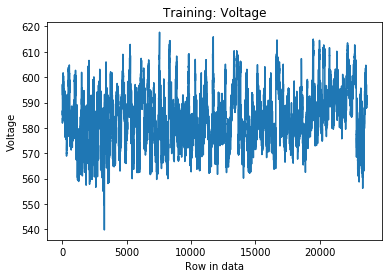

In [67]:
plt.plot(np.arange(len(training_data)),training_data['Voltage'][0:len(training_data)])
plt.ylabel('Voltage')
plt.xlabel('Row in data')
plt.title('Training: Voltage')


### Normalizing the new data



In [68]:
training_data = training_data.reset_index(drop=True)

In [69]:
training_data.iloc[0]['deltaSOC'] = training_data.iloc[1]['deltaSOC']

/Users/germa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [70]:
training_data.iloc[0]['deltaSOC'] = training_data.iloc[1]['deltaSOC']


/Users/germa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [71]:
# Setting timestamp as index

#training_data = training_data.set_index('ts')
training_data.head()



,Battery(kW),State of Charge,Total Net Load (Sum of All Loads excluding Battery),ts,Building(kW),Adjusted Load (kW),Ampere,Voltage,deltaSOC,Year,Week,Hour,Day,values,date,Triple,Pairs
0,-22.800101,0.572250,1975.492339,2019-06-01 04:15:00,1975.492339,1952.692237,2111.85,583.6,0.013387,2019,22,4,5,2,2019-06-01,"(22, 2, 2019-06-01)","(22, 2)"
1,139.599885,0.585636,1976.813313,2019-06-01 04:30:00,1976.813313,2116.413198,2167.47,582.3,0.013387,2019,22,4,5,2,2019-06-01,"(22, 2, 2019-06-01)","(22, 2)"
2,-7.200152,0.583871,1995.591711,2019-06-01 04:45:00,1995.591711,1988.391559,2029.17,583.4,-0.001765,2019,22,4,5,2,2019-06-01,"(22, 2, 2019-06-01)","(22, 2)"
3,-513.599510,0.527619,1945.208337,2019-06-01 05:00:00,1945.208337,1431.608827,1403.33,586.8,-0.056251,2019,22,5,5,2,2019-06-01,"(22, 2, 2019-06-01)","(22, 2)"
4,128.401671,0.542111,1978.229553,2019-06-01 05:15:00,1978.229553,2106.631224,2208.09,581.9,0.014492,2019,22,5,5,2,2019-06-01,"(22, 2, 2019-06-01)","(22, 2)"


In [72]:
train_matlab = training_data.set_index('ts').drop(columns = ['values','date','Triple','Pairs','Year','Total Net Load (Sum of All Loads excluding Battery)'], axis = 1)





In [74]:
stats2 = train_matlab.describe()
stats2 = stats2.transpose()

In [75]:
def norm4(data):
    return (2*(data - stats2['min'])/(stats2['max']-stats2['min']) - 1)



In [76]:
testing_matlab = testing_data.set_index('ts').drop(columns = ['values','Triple','Pairs','Year','Total Net Load (Sum of All Loads excluding Battery)','date'], axis = 1)

dataset = MN.drop(columns = ['values','ts','Triple','Pairs','Year','Total Net Load (Sum of All Loads excluding Battery)','date'], axis = 1)

# Use the whole dataset to normalize before splitting 



In [77]:
# The following is for the testing data 
stats3 = dataset.describe()
stats3 = stats3.transpose()


def norm5(data):
    return (2*(data - stats3['min'])/(stats3['max']-stats3['min']) - 1)

train_normalized = norm5(train_matlab)




## Filter out the outliers 


In [78]:

# Convert data to matlab

#train_normalized.to_csv('training_normalized')

test_normalized = norm5(testing_matlab)

tr_outli = (train_normalized['deltaSOC']>0.5)|(train_normalized['deltaSOC']<-0.5)

train_normalized2 = train_normalized[~tr_outli]



In [79]:

#Check PyTorch, Keras

# This is for Testing 

#test_normalized.to_csv('test_normalized.csv')

#test_normalized.to_csv('test_normalized')

te_outli = (test_normalized['deltaSOC']>0.5)|(test_normalized['deltaSOC']<-0.5)

test_normalized2 = test_normalized[~te_outli]



Text(0.5, 1.0, 'Testing: deltaSOC')

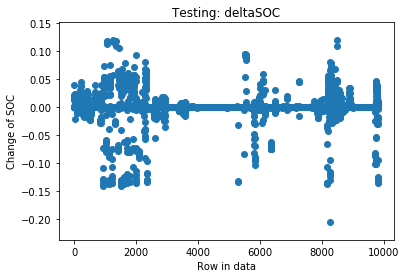

In [80]:
plt.scatter(np.arange(len(test_normalized)),test_normalized['deltaSOC'][0:len(testing_data)])
plt.ylabel('Change of SOC')
plt.xlabel('Row in data')
plt.title('Testing: deltaSOC')



Text(0.5, 1.0, 'Training: Battery power')

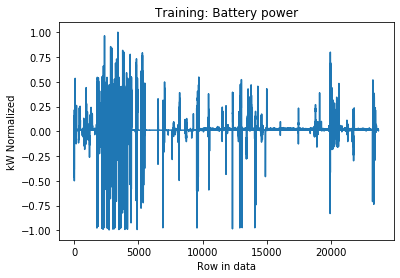

In [81]:
plt.plot(np.arange(len(train_normalized)),train_normalized['Battery(kW)'][0:len(training_data)])
plt.ylabel('kW Normalized')
plt.xlabel('Row in data')
plt.title('Training: Battery power')


Text(0.5, 1.0, 'Test: Battery power')

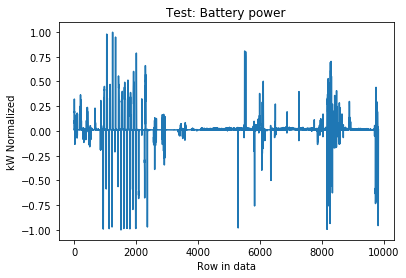

In [135]:
plt.plot(np.arange(len(test_normalized)),test_normalized['Battery(kW)'][0:len(test_normalized)])
plt.ylabel('kW Normalized')
plt.xlabel('Row in data')
plt.title('Test: Battery power')




In [139]:
# train_normalized2.to_csv('train_normalized2')
# test_normalized2.to_csv('test_normalized2')
